In [57]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from scipy.integrate import quad
from IPython.display import HTML

### BSM model

In [53]:
def dN(x):
    return math.exp(-0.5*x**2)/math.sqrt(2*math.pi)

def N(d):
    return quad(lambda x:dN(x),-20,d,limit=50)[0]

def d1f(St, K, t, T, r, sigma):
    d1 = (math.log(St / K) + (r + 0.5 * sigma ** 2) * (T - t)) / (sigma * math.sqrt(T - t))
    return d1

def BSM_call_value(St, K, t, T, r, sigma):
    d1=d1f(St,K,t,T,r,sigma)
    d2=d1-sigma*math.sqrt(T-t)
    call_value = St * N(d1) - math.exp(-r * (T - t)) * K * N(d2)
    return call_value

def BSM_put_value(St, K, t, T, r, sigma):
    put_value = BSM_call_value(St,K,t,T,r,sigma)-St + math.exp(-r * (T - t)) * K
    return put_value

### Greeks

In [97]:
table = """<table><tr><th>Greek</th><th>Call<pre>                           </pre></th><th>Put<pre>                           </pre></th></tr><tr><td>Delta $\Delta$</td><td>$N(d_1)$</td><td>$-N(-d_1)$</td></tr><tr><td>Theta $\Theta$</td><td>$\\frac{-\sigma SN'(d_1)}{2\sqrt{T-t}} - rKe^{-r(T-t)} N(d_2)$</td><td>$\\frac{-\sigma SN'(d_1)}{2\sqrt{T-t}} + rKe^{-r(T-t)} N(d_2)$</td></tr><tr><td>Gamma $\Gamma$</td><td>$\\frac{N'(d_1)}{S\sigma \sqrt{T}}$</td><td>$\\frac{N'(d_1)}{S\sigma \sqrt{T}}$</td></tr><tr><td>Vega $v$</td><td>$S_0 N'(d_1)\sqrt{T}$</td><td>$S_0 N'(d_1)\sqrt{T}$</td></tr><tr><td>Rho $\\rho$</td><td>$TKe^{-r(T)} N(d_2)$</td><td>$-TKe^{-r(T)} N(-d_2)$</td></tr></table>"""
HTML(table)

Greek,Call,Put
Delta $\Delta$,$N(d_1)$,$-N(-d_1)$
Theta $\Theta$,$\frac{-\sigma SN'(d_1)}{2\sqrt{T-t}} - rKe^{-r(T-t)} N(d_2)$,$\frac{-\sigma SN'(d_1)}{2\sqrt{T-t}} + rKe^{-r(T-t)} N(d_2)$
Gamma $\Gamma$,$\frac{N'(d_1)}{S\sigma \sqrt{T}}$,$\frac{N'(d_1)}{S\sigma \sqrt{T}}$
Vega $v$,$S_0 N'(d_1)\sqrt{T}$,$S_0 N'(d_1)\sqrt{T}$
Rho $\rho$,$TKe^{-r(T)} N(d_2)$,$-TKe^{-r(T)} N(-d_2)$


In [55]:
def BSM_delta (St, K, t, T, r, sigma):
    d1=d1f(St, K, t, T, r, sigma)
    delta=N(d1)
    return delta

def BSM_gamma(St, K, t, T, r, sigma):
    d1=d1f(St, K, t, T, r, sigma)
    gamma=dN(d1) / (St * sigma*math.sqrt(T-t))
    return gamma

def BSM_theta(St, K, t, T, r,sigma):
    d1 = d1f(St, K, t, T, r, sigma)
    d2 = d1 - sigma * math.sqrt(T - t)
    theta = -(St * dN(d1) * sigma / (2 * math.sqrt(T - t))
              + r * K * math.exp(-r * (T - t)) * N(d2))
    return theta

def BSM_rho(St, K, t, T, r, sigma):
    d1 = d1f(St, K, t, T, r, sigma)
    d2 = d1 - sigma * math.sqrt(T - t)
    rho = K * (T - t) * math.exp(-r * (T - t)) * N(d2)
    return rho

def BSM_vega(St, K, t, T, r, sigma):
    d1 = d1f(St, K, t, T, r, sigma)
    vega = St * dN(d1) * math.sqrt(T - t)
    return vega

def BSM_vanna(St, K, t, T, r, sigma):
    d1 = d1f(St, K, t, T, r, sigma)
    d2 = d1 - sigma * math.sqrt(T - t)
    return dN(d1) * (-d2) / sigma

### Plot

In [124]:
def plot_greeks(function, greek, tar="ST", ran=0.3, K=100, S=100, T=True):

    # model parameters
    St_ = S  # index level
    K_ = K  # option strike
    t_ = -0.001  # valuation date
    T_ = 1.0  # maturity date
    r_ = 0.05  # risk-less short rate
    sigma_ = 0.5  # volatility
    # Greek Calculations
    tlist = (np.linspace(0.01, 1, 100) if isinstance(T, bool) else np.linspace(T[0], T[-1], 100)) if "T" in tar else np.ones(100) * 0.1
    slist = np.linspace(1 - ran, 1 + ran, 100) * St_ if "S" in tar else np.ones(100) * St_
    klist = np.linspace(1 - ran, 1 + ran, 100) * K_
    sigmalist = np.linspace(1 - ran, 1 + ran, 100) * sigma_ if "V" in tar else np.ones(100) * sigma_
    V = np.zeros((len(tlist), len(slist)), dtype=np.float)
    for j in range(len(slist)):
        for i in range(len(tlist)):
            V[i, j] = function(slist[j], K_, t_, tlist[i], r_, sigmalist[i])

    # 3D Plotting
    x, y = np.meshgrid(slist, tlist if "T" in tar else sigmalist)
    fig = plt.figure(figsize=(9, 5))
    plot = Axes3D(fig)
    plot.plot_surface(x, y, V, cmap=plt.get_cmap('bone'))
    plot.set_xlabel('stock $S$')
    plot.set_ylabel('maturity $T$' if "T" in tar else 'vol $\sigma$')
    plot.set_zlabel('%s' % greek)

In [167]:
def plot_greeks_2nd(function, greek, tar="V", K=[95, 100, 105], S=100, ran=0.3, T=True):

    # model parameters
    St_ = S  # index level
    K_ = K  # option strike
    t_ = -0.001  # valuation date
    T_ = 1.0  # maturity date
    r_ = 0.05  # risk-less short rate
    sigma_ = 0.5  # volatility
    # Greek Calculations
    tlist = np.linspace(0.01, 1, 100) if "T" in tar else np.ones(100) * 0.1
    slist = np.ones(100) * St_
    sigmalist = np.linspace(1 - ran, 1 + ran, 100) * sigma_ if "V" in tar else np.ones(100) * sigma_
    V = np.zeros(((len(tlist)), len(K_)), dtype=np.float)
    for i in range(len(tlist)):
        for j in range(len(K_)):        
            V[i, j] = function(St_, K_[j], t_, tlist[i], r_, sigmalist[i])

    plt.plot(V, sigmalist if "V" in tar else tlist)
    # 3D Plotting
#     x, y = np.meshgrid(slist, tlist if "T" in tar else sigmalist)
#     fig = plt.figure(figsize=(9, 5))
#     plot = Axes3D(fig)
#     plot.plot_surface(x, y, V, cmap=plt.get_cmap('bone'))
#     plot.set_xlabel('stock $S$')
#     plot.set_ylabel('maturity $T$' if "T" in tar else 'vol $\sigma$')
#     plot.set_zlabel('%s' % greek)
    return V

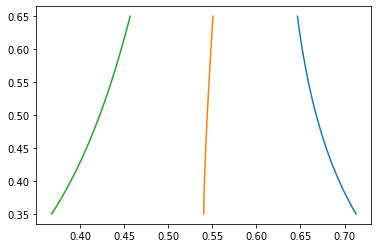

In [168]:
a = plot_greeks_2nd(BSM_delta, "delta")

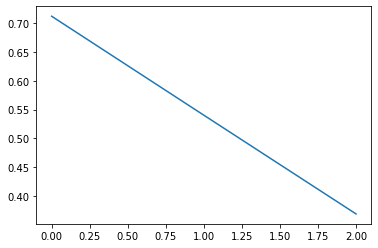

In [169]:
plt.plot(a[1])

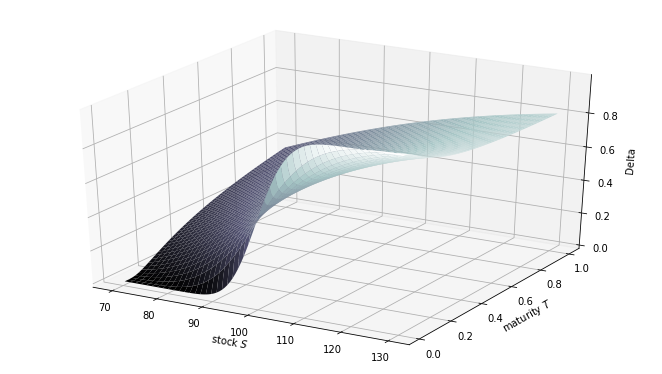

In [72]:
plot_greeks(BSM_delta,"Delta")

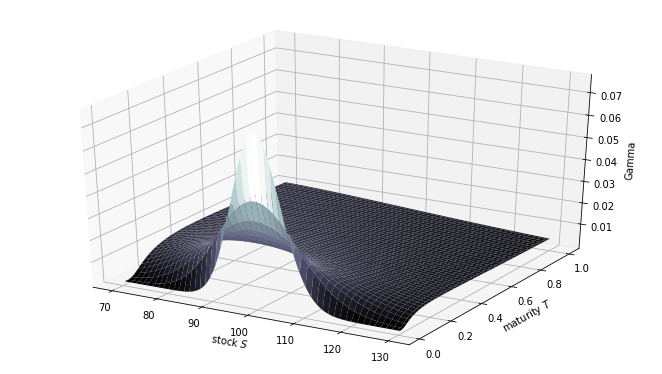

In [61]:
plot_greeks(BSM_gamma,"Gamma")

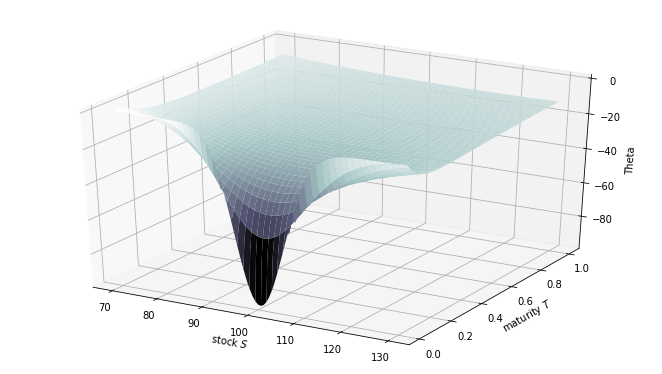

In [62]:
plot_greeks(BSM_theta,"Theta")

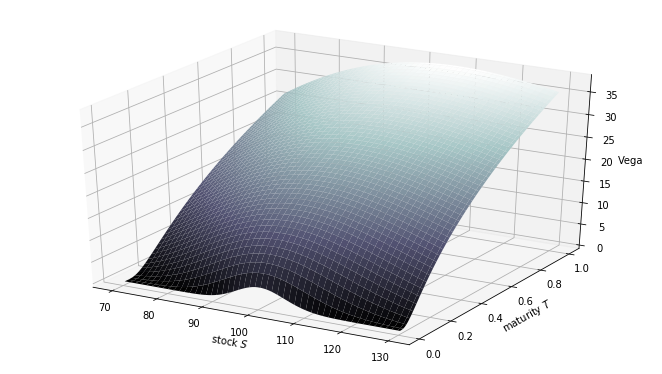

In [63]:
plot_greeks(BSM_vega,"Vega")

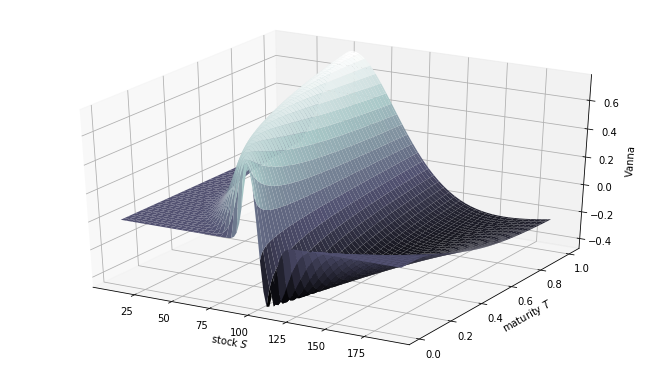

In [118]:
plot_greeks(BSM_vanna,"Vanna", ran=0.9)

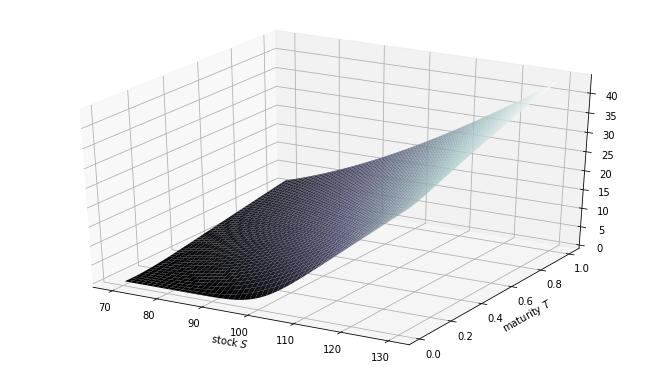

In [65]:
plot_greeks(BSM_call_value, "")

## $\sigma$ 對greek的影響 固定T

### Delta 
##### $\sigma$ 變大 價內會變小 價外會變大

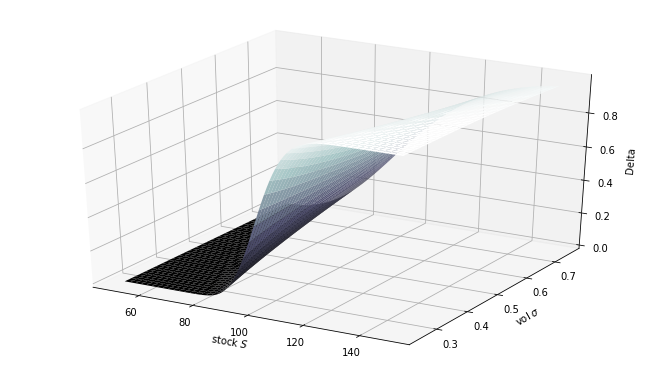

In [99]:
plot_greeks(BSM_delta,"Delta", "SV", ran=0.5)

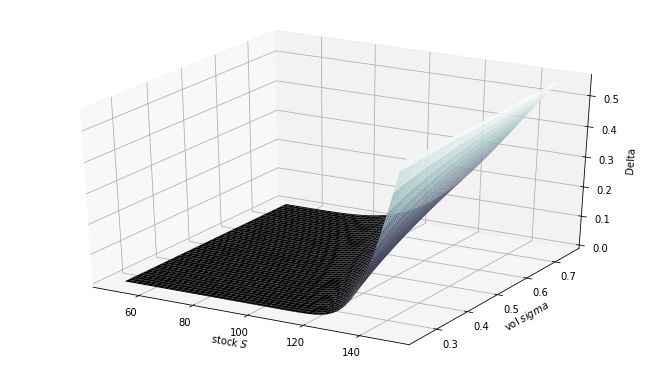

In [87]:
plot_greeks(BSM_delta,"Delta", "SV", ran=0.5, K=150)#價外

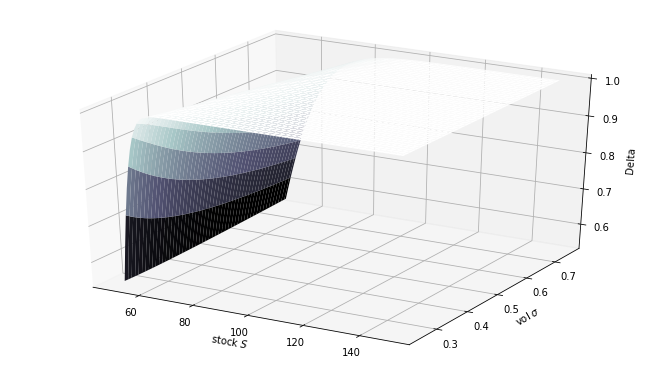

In [121]:
plot_greeks(BSM_delta,"Delta", "SV", ran=0.5, K=50)#價內

### Gamma 
##### $\Gamma$ 變大 價內價外都變大

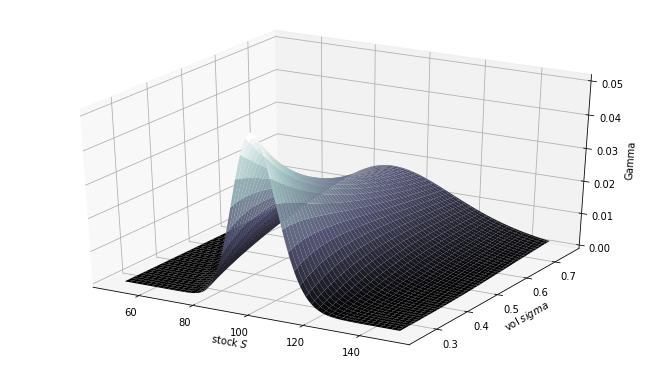

In [91]:
plot_greeks(BSM_gamma,"Gamma", "SV", ran=0.5)

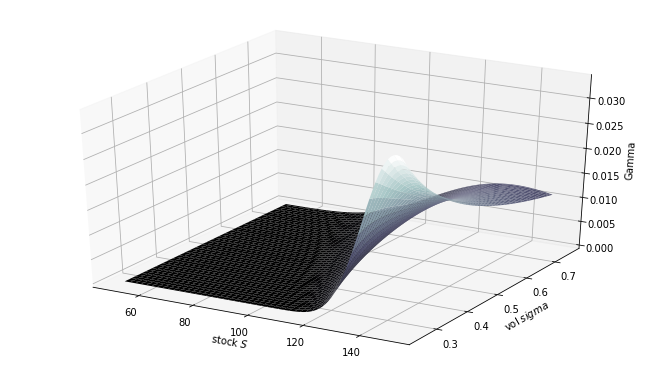

In [95]:
plot_greeks(BSM_gamma,"Gamma", "SV", ran=0.5, K=150)#價外

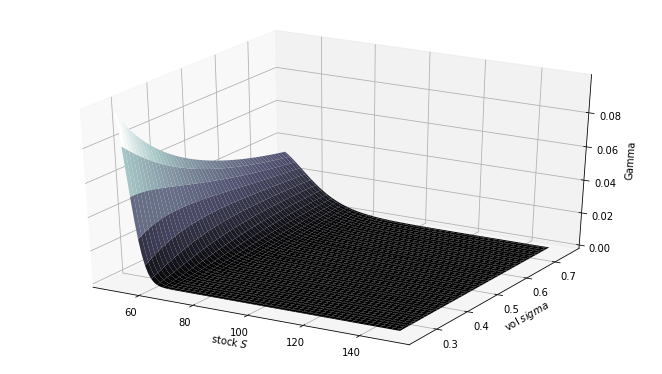

In [96]:
plot_greeks(BSM_gamma,"Gamma", "SV", ran=0.5, K=50)#價內

### Theta 
##### $\Theta$ 變大 價內價外都變大(負更多)

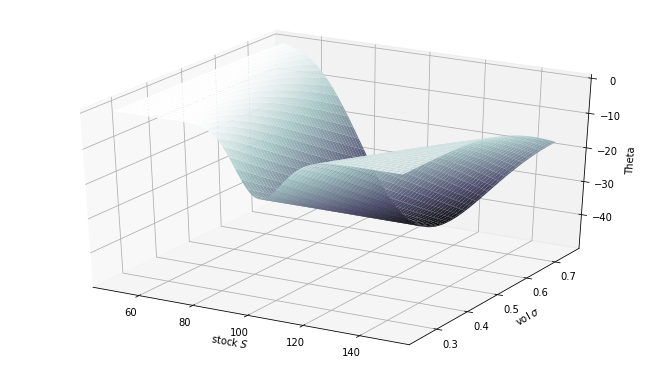

In [109]:
plot_greeks(BSM_theta,"Theta", "SV", ran=0.5)

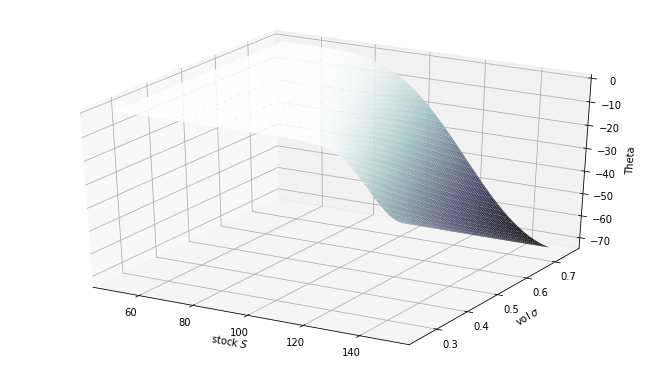

In [110]:
plot_greeks(BSM_theta,"Theta", "SV", ran=0.5, K=150)#價外

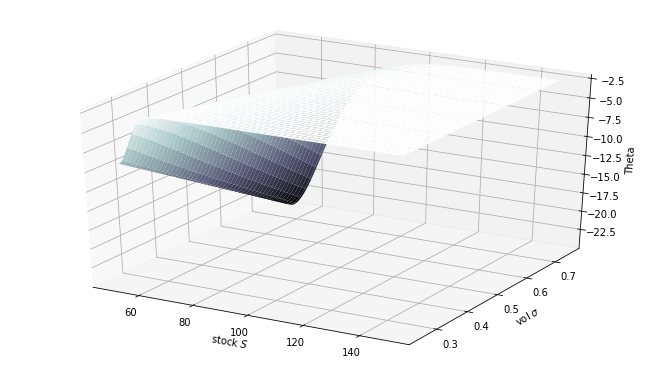

In [111]:
plot_greeks(BSM_theta,"Theta", "SV", ran=0.5, K=50)#價內

### Vega 
##### $v$ 變大 價內價外都變大

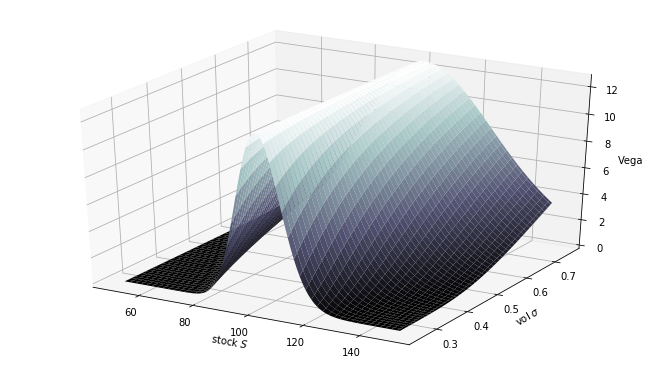

In [115]:
plot_greeks(BSM_vega,"Vega", "SV", ran=0.5)

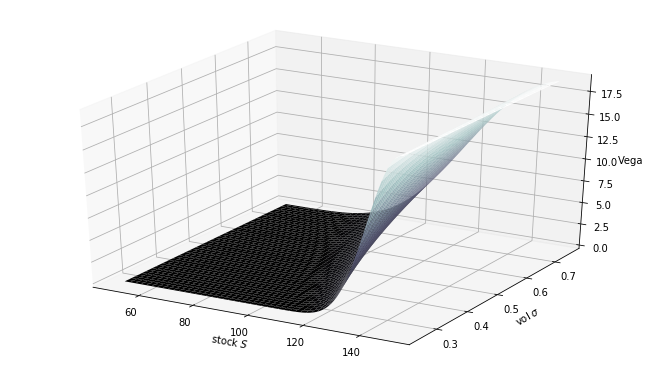

In [116]:
plot_greeks(BSM_vega,"Vega", "SV", ran=0.5, K=150)#價外

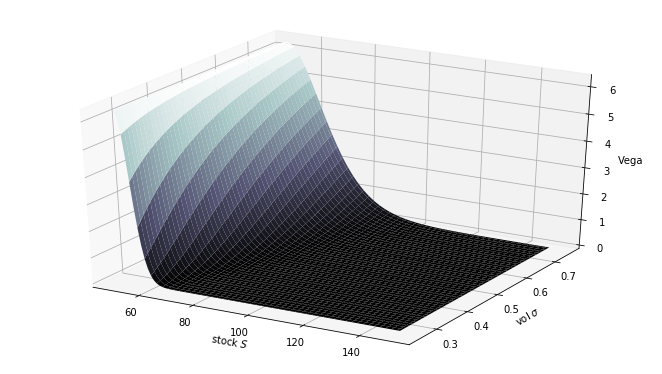

In [117]:
plot_greeks(BSM_vega,"Vega", "SV", ran=0.5, K=50)#價內

In [1]:
import numpy as np

In [15]:
n = 5

In [19]:
A = lambda n : np.diag(np.ones(n-1), -1) + np.diag(np.ones(n) * 2, 0) + np.diag(np.ones(n-1), 1)

In [39]:
S = lambda n : {"inv" : np.linalg.inv(A(n)), "det" : np.linalg.det(A(n)), "pro" : np.linalg.inv(A(n)) * np.linalg.det(A(n))}

In [20]:
A(n)

array([[2., 1., 0., 0., 0.],
       [1., 2., 1., 0., 0.],
       [0., 1., 2., 1., 0.],
       [0., 0., 1., 2., 1.],
       [0., 0., 0., 1., 2.]])

In [40]:
S(4)

{'inv': array([[ 0.8, -0.6,  0.4, -0.2],
        [-0.6,  1.2, -0.8,  0.4],
        [ 0.4, -0.8,  1.2, -0.6],
        [-0.2,  0.4, -0.6,  0.8]]),
 'det': 4.999999999999999,
 'pro': array([[ 4., -3.,  2., -1.],
        [-3.,  6., -4.,  2.],
        [ 2., -4.,  6., -3.],
        [-1.,  2., -3.,  4.]])}

In [41]:
S(5)

{'inv': array([[ 0.83333333, -0.66666667,  0.5       , -0.33333333,  0.16666667],
        [-0.66666667,  1.33333333, -1.        ,  0.66666667, -0.33333333],
        [ 0.5       , -1.        ,  1.5       , -1.        ,  0.5       ],
        [-0.33333333,  0.66666667, -1.        ,  1.33333333, -0.66666667],
        [ 0.16666667, -0.33333333,  0.5       , -0.66666667,  0.83333333]]),
 'det': 6.0,
 'pro': array([[ 5., -4.,  3., -2.,  1.],
        [-4.,  8., -6.,  4., -2.],
        [ 3., -6.,  9., -6.,  3.],
        [-2.,  4., -6.,  8., -4.],
        [ 1., -2.,  3., -4.,  5.]])}

In [42]:
S(6)

{'inv': array([[ 0.85714286, -0.71428571,  0.57142857, -0.42857143,  0.28571429,
         -0.14285714],
        [-0.71428571,  1.42857143, -1.14285714,  0.85714286, -0.57142857,
          0.28571429],
        [ 0.57142857, -1.14285714,  1.71428571, -1.28571429,  0.85714286,
         -0.42857143],
        [-0.42857143,  0.85714286, -1.28571429,  1.71428571, -1.14285714,
          0.57142857],
        [ 0.28571429, -0.57142857,  0.85714286, -1.14285714,  1.42857143,
         -0.71428571],
        [-0.14285714,  0.28571429, -0.42857143,  0.57142857, -0.71428571,
          0.85714286]]),
 'det': 6.999999999999999,
 'pro': array([[ 6., -5.,  4., -3.,  2., -1.],
        [-5., 10., -8.,  6., -4.,  2.],
        [ 4., -8., 12., -9.,  6., -3.],
        [-3.,  6., -9., 12., -8.,  4.],
        [ 2., -4.,  6., -8., 10., -5.],
        [-1.,  2., -3.,  4., -5.,  6.]])}

In [43]:
S(10)

{'inv': array([[ 0.90909091, -0.81818182,  0.72727273, -0.63636364,  0.54545455,
         -0.45454545,  0.36363636, -0.27272727,  0.18181818, -0.09090909],
        [-0.81818182,  1.63636364, -1.45454545,  1.27272727, -1.09090909,
          0.90909091, -0.72727273,  0.54545455, -0.36363636,  0.18181818],
        [ 0.72727273, -1.45454545,  2.18181818, -1.90909091,  1.63636364,
         -1.36363636,  1.09090909, -0.81818182,  0.54545455, -0.27272727],
        [-0.63636364,  1.27272727, -1.90909091,  2.54545455, -2.18181818,
          1.81818182, -1.45454545,  1.09090909, -0.72727273,  0.36363636],
        [ 0.54545455, -1.09090909,  1.63636364, -2.18181818,  2.72727273,
         -2.27272727,  1.81818182, -1.36363636,  0.90909091, -0.45454545],
        [-0.45454545,  0.90909091, -1.36363636,  1.81818182, -2.27272727,
          2.72727273, -2.18181818,  1.63636364, -1.09090909,  0.54545455],
        [ 0.36363636, -0.72727273,  1.09090909, -1.45454545,  1.81818182,
         -2.18181818,  2.

In [ ]:
P[i, j] = n

In [ ]:
"""

"""